In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PreyPolicy import PreyPolicy
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation
import custom_marl_aquarium

ModuleNotFoundError: No module named 'marl_aquarium'

In [5]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Video Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy(gain=0.0).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device="cpu")

start_frame_pool = Pool(max_length=12100, device="cpu")
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

NameError: name 'scale' is not defined

In [7]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(traj_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
expert_buffer.add_expert(hl_path)
expert_buffer.add_expert(hl_path)

len_exp_pred, len_exp_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  23000
Storage of Prey Expert Buffer:  200000 



[PREDATOR] Epoch 01 | Train Loss: 0.607608 | Val Loss: 0.462890
[PREDATOR] Epoch 02 | Train Loss: 0.536918 | Val Loss: 0.574615
[PREDATOR] Epoch 03 | Train Loss: 0.424657 | Val Loss: 0.580454
[PREDATOR] Epoch 04 | Train Loss: 0.512414 | Val Loss: 0.759014
[PREDATOR] Epoch 05 | Train Loss: 0.448705 | Val Loss: 1.022341
[PREDATOR] Epoch 06 | Train Loss: 0.406830 | Val Loss: 0.918936
[PREDATOR] Epoch 07 | Train Loss: 0.405617 | Val Loss: 0.882898
[PREDATOR] Epoch 08 | Train Loss: 0.449334 | Val Loss: 0.690578
[PREDATOR] Epoch 09 | Train Loss: 0.481921 | Val Loss: 0.799572
[PREDATOR] Epoch 10 | Train Loss: 0.465640 | Val Loss: 0.830147
[PREDATOR] Epoch 11 | Train Loss: 0.472042 | Val Loss: 0.690821
[PREDATOR] Epoch 12 | Train Loss: 0.388110 | Val Loss: 0.618125
[PREDATOR] Epoch 13 | Train Loss: 0.579634 | Val Loss: 0.457835
[PREDATOR] Epoch 14 | Train Loss: 0.434727 | Val Loss: 0.571446
[PREDATOR] Epoch 15 | Train Loss: 0.381655 | Val Loss: 0.704338
[PREDATOR] Epoch 16 | Train Loss: 0.4203

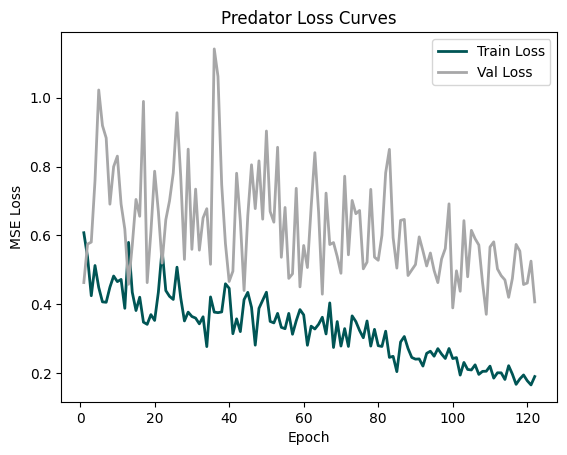

In [8]:
pred_policy, pred_logs = pretrain_policy_with_validation(pred_policy, prey_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=500, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(pred_policy, os.path.join(save_dir, "bc_pred_policy.pt"))

with open(os.path.join(save_dir, "bc_pred_logs.pkl"), "wb") as f:
    pickle.dump(pred_logs, f)

[PREY] Epoch 01 | Train Loss: 0.541677 | Val Loss: 0.492502 | Pred Gain: 0.0540766566991806
[PREY] Epoch 02 | Train Loss: 0.512458 | Val Loss: 0.460590 | Pred Gain: 0.05319339036941528
[PREY] Epoch 03 | Train Loss: 0.500810 | Val Loss: 0.467150 | Pred Gain: 0.03095233626663685
[PREY] Epoch 04 | Train Loss: 0.499132 | Val Loss: 0.486734 | Pred Gain: 0.04273948073387146
[PREY] Epoch 05 | Train Loss: 0.460975 | Val Loss: 0.490020 | Pred Gain: 0.030743738636374474
[PREY] Epoch 06 | Train Loss: 0.461237 | Val Loss: 0.502232 | Pred Gain: 0.05019543319940567
[PREY] Epoch 07 | Train Loss: 0.458257 | Val Loss: 0.468695 | Pred Gain: 0.048745106905698776
[PREY] Epoch 08 | Train Loss: 0.482364 | Val Loss: 0.499832 | Pred Gain: 0.053811512887477875
[PREY] Epoch 09 | Train Loss: 0.456612 | Val Loss: 0.481814 | Pred Gain: 0.043582845479249954
[PREY] Epoch 10 | Train Loss: 0.457071 | Val Loss: 0.487348 | Pred Gain: 0.025738699361681938
[PREY] Epoch 11 | Train Loss: 0.449728 | Val Loss: 0.461894 | Pred

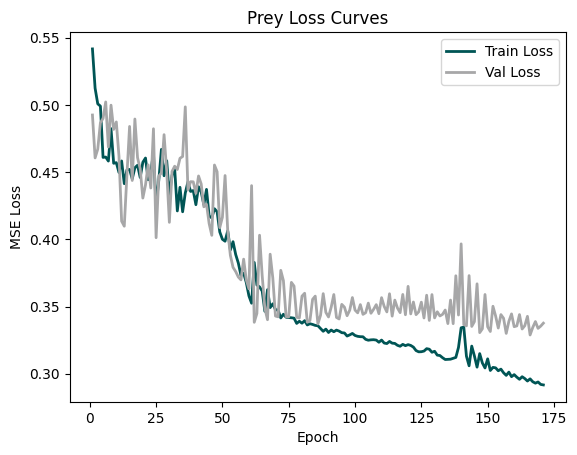

In [9]:
prey_policy, prey_logs = pretrain_policy_with_validation(prey_policy, pred_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=1000, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(prey_policy, os.path.join(save_dir, "bc_prey_policy.pt"))

with open(os.path.join(save_dir, "bc_prey_logs.pkl"), "wb") as f:
    pickle.dump(prey_logs, f)

In [10]:
env = parallel_env(use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

NameError: name 'parallel_env' is not defined